In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

from tspiral.model_selection import TemporalSplit
from tspiral.forecasting import ForecastingCascade

In [2]:
### UTLITY FUNCTIONS FOR SYNTETIC DATA GENERATION ###

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y


def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

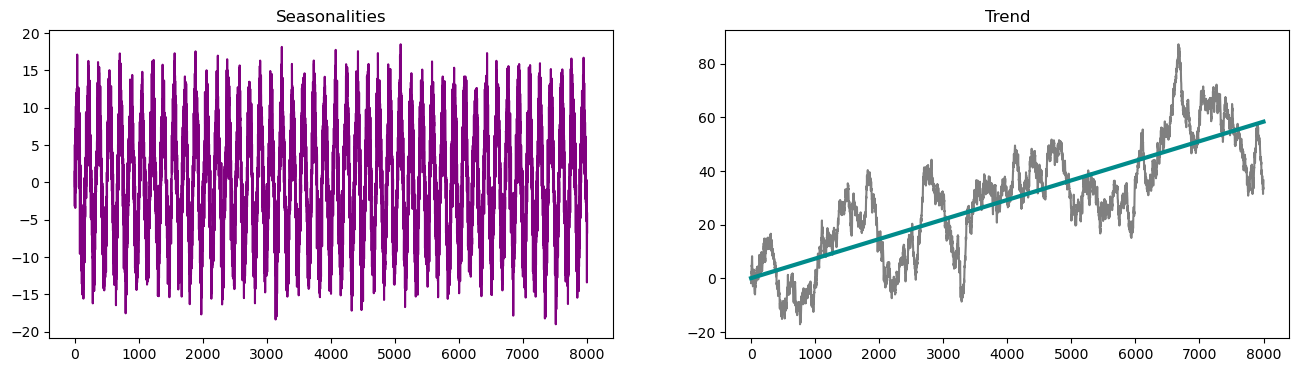

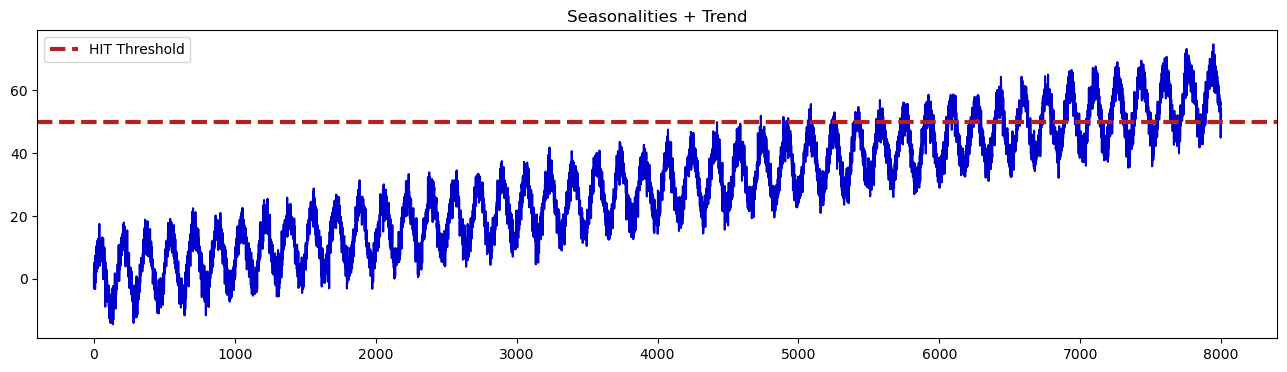

In [3]:
### EXAMPLE OF SYNTETIC DATA GENERATION ###

np.random.seed(1234)
timesteps = 8_000
seas = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=3)

rw = gen_randomwalk(timesteps=timesteps, noise=1)
X = np.linspace(0,10, timesteps).reshape(-1,1)
X = np.power(X, [1])
m = LinearRegression()
trend = m.fit(X, rw).predict(X)
y = seas + trend

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(seas, c='purple'); plt.title('Seasonalities')
plt.subplot(122)
plt.plot(rw, c='grey'); plt.plot(trend, c='darkcyan',linewidth=3); plt.title('Trend')

plt.figure(figsize=(16,4))
plt.plot(y, c='mediumblue'); plt.title('Seasonalities + Trend')
plt.axhline(50, c='firebrick', label='HIT Threshold',
            linestyle='--', linewidth=3)
plt.legend()
plt.show()

In [4]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    np.zeros((timesteps,1)), y, 
    test_size=2_000, shuffle=False
)

CV = TemporalSplit(n_splits=10, test_size=y_test.shape[0], gap=24)

In [5]:
### COMPUTE PREDICTIONS ON TRAINSET THROUGHT CROSS-VALIDATION ###

model = ForecastingCascade(
    Ridge(),
    lags=range(1,24*7+1),
    groups=[0],
)

pred_val_matrix = np.full(
    shape=(X_train.shape[0], CV.get_n_splits(X_train)),
    fill_value=np.nan,
    dtype=float,
)

for i, (id_train, id_val) in tqdm(enumerate(CV.split(X_train)), 
                                  total=pred_val_matrix.shape[1]):
    
    pred_val = model.fit(
        X_train[id_train], 
        y_train[id_train]
    ).predict(X_train[id_val])
    
    pred_val_matrix[id_val, i] = np.array(
        pred_val, dtype=float
    )

    
y_pred = model.fit(
    X_train, 
    y_train
).predict(X_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.31it/s]


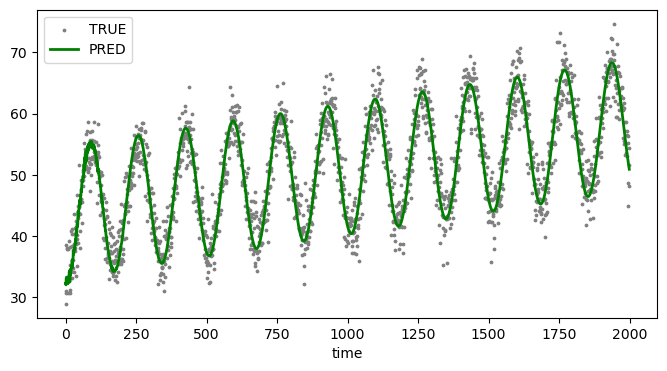

In [6]:
### PLOT TRUE VS PREDICTION ###

plt.figure(figsize=(8,4))
plt.scatter(np.arange(X_test.shape[0]), y_test, s=3, c='grey', label='TRUE')
plt.plot(np.arange(X_test.shape[0]), y_pred, c='green', linewidth=2, label='PRED')
plt.xlabel('time'); plt.legend()
plt.show()

In [7]:
### GET CONFORMITY SCORES AND POINTWISE TEST DISTRIBUTIONS ###

pred_val = np.nanmean(pred_val_matrix, axis=1)

conformity_scores  = np.abs(
    np.subtract(
        y_train[~np.isnan(pred_val)], 
        pred_val[~np.isnan(pred_val)]
    )
)
    
estimated_test_distributions = np.add(y_pred[:, None], conformity_scores)

estimated_test_distributions.shape

C:\Users\marco.cerliani\AppData\Local\Temp\ipykernel_4136\1929104227.py:3: RuntimeWarning: Mean of empty slice
  pred_val = np.nanmean(pred_val_matrix, axis=1)


(2000, 2216)

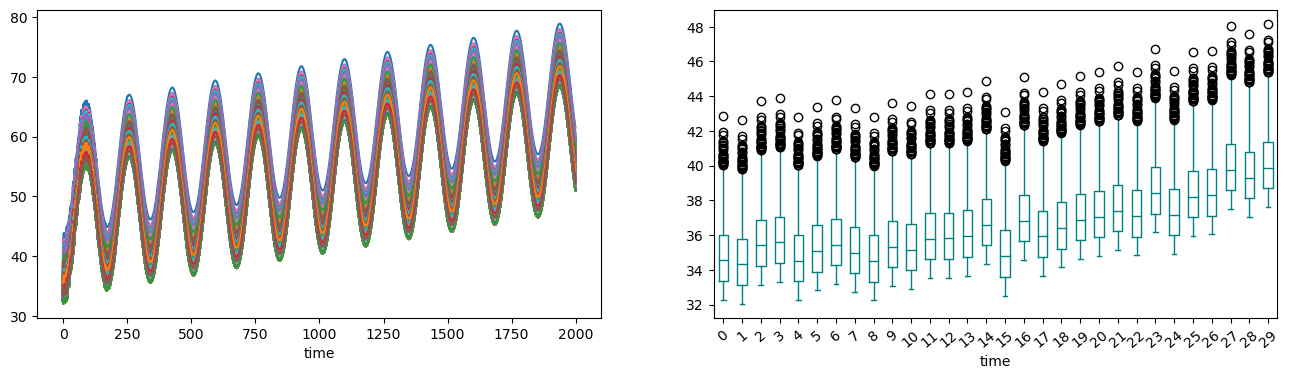

In [8]:
### PLOT TEST PREDICTION DISTRIBUTIONS ###

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(np.arange(X_test.shape[0]), estimated_test_distributions)
plt.xlabel('time')
plt.subplot(122)
pd.DataFrame(
    estimated_test_distributions,
).head(30).T.boxplot(grid=False, color='teal')
plt.xticks(rotation=40); plt.xlabel('time')
plt.show()

In [9]:
### OBTAIN AND PROCESS PROBABILITY CURVE ###

THRESHOLD = 60

prob_test = np.mean(estimated_test_distributions > THRESHOLD, axis=1)

prob_test = pd.Series(prob_test).expanding(1).max().values

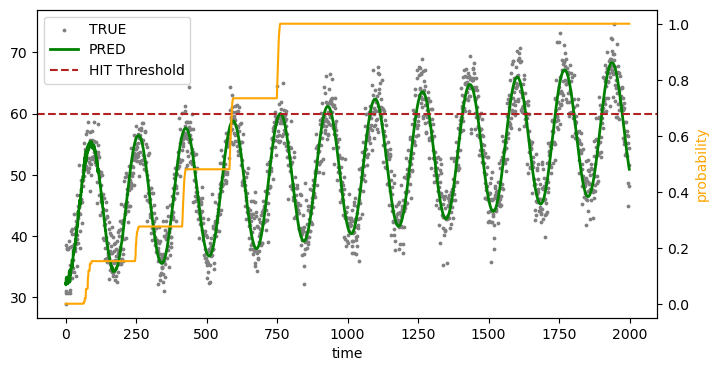

In [10]:
### PLOT TRUE VS PREDICTION PLUS PROBABILITY CURVE ###

plt.figure(figsize=(8,4))
plt.scatter(np.arange(X_test.shape[0]), y_test, s=3, c='grey', label='TRUE')
plt.plot(np.arange(X_test.shape[0]), y_pred, c='green', linewidth=2, label='PRED')
plt.axhline(THRESHOLD, c='firebrick', linestyle='--', label='HIT Threshold')
plt.xlabel('time'); plt.legend()
plt.twinx()
plt.plot(np.arange(X_test.shape[0]), prob_test, c='orange')
plt.ylabel('probability', color='orange')
plt.show()